In [1]:
from lib import *

Pipeline = pipeline.Pipeline
RegressionValidator = pipeline.RegressionValidator

DatasetProvider = provider.DatasetProvider
DatasetUploader = provider.DatasetUploader

In [2]:
import warnings

from sklearn.exceptions import ConvergenceWarning, DataConversionWarning

warnings.filterwarnings('ignore', category=DataConversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.linear_model import Ridge, LinearRegression, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler

from tqdm._tqdm_notebook import tqdm_notebook
from tqdm._tqdm_notebook import tqdm
tqdm_notebook.pandas()

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

/tmp/ipykernel_19509/2953650914.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


In [4]:
FETCH_BACKUP = True

## Load train, test sets, idx's

In [5]:
import pickle

def load_pickle(dataset, name):
    dataset.to_pickle(name + '.pkl')

def from_pickle(path):
    with open(path, 'rb') as reader:
        return pickle.load(reader)

In [6]:
dataset_paths = [
    '/home/denissimo/Repo/fs_project/datasets/sample_submission.csv',
    '/home/denissimo/Repo/fs_project/datasets/test.csv',
]

df_provider = DatasetProvider()
df_provider.file_list = dataset_paths
datasets = df_provider.get_dataset()

In [7]:
task_df = {}

task_df['test'] = from_pickle('tmp/task_df_test.pkl')
task_df['train'] = from_pickle('tmp/task_df_train.pkl')
task_df['idx'] = from_pickle('tmp/idx.pkl')

In [8]:
MAP = datasets['test.csv'].merge(
    task_df['idx'][['shop_id', 'item_id', 'id']],
    on=['shop_id', 'item_id'],
    how='left'
)

In [9]:
MAP

,ID,shop_id,item_id,id
0,0,5,5037,485225
1,1,5,5320,364565
2,2,5,5233,486065
3,3,5,5232,566225
4,4,5,5268,1074185
...,...,...,...,...
214195,214195,45,18454,451545
214196,214196,45,16188,1211325
214197,214197,45,15757,435525
214198,214198,45,19648,260805


In [10]:
baseline_train = from_pickle('tmp/baseline_model_training_set.pkl')
validation_set = from_pickle('tmp/baseline_model_tuning_set.pkl')
test_set = from_pickle('tmp/baseline_model_validation_set.pkl')
submition_set = from_pickle('tmp/baseline_submission_set.pkl')

In [11]:
test_set['dynamic_aggregation'].columns

Index(['mean_win_2', 'std_win_2', 'min_win_2', 'max_win_2', 'mean_win_4',
       'std_win_4', 'min_win_4', 'max_win_4', 'mean_win_6', 'std_win_6',
       'min_win_6', 'max_win_6', 'mean_win_12', 'std_win_12', 'min_win_12',
       'max_win_12', 'mean_win_33', 'std_win_33', 'min_win_33', 'max_win_33'],
      dtype='object')

In [12]:
for key in baseline_train:
    if not key in ['target', 'lags']:
        baseline_train[key].columns = [f'{key}_{agg_type}' for agg_type in baseline_train[key].columns.values]
        validation_set[key].columns = [f'{key}_{agg_type}' for agg_type in validation_set[key].columns.values]
        submition_set[key].columns = [f'{key}_{agg_type}' for agg_type in submition_set[key].columns.values]
        test_set[key].columns = [f'{key}_{agg_type}' for agg_type in test_set[key].columns.values]

In [13]:
full_train = pd.concat(baseline_train.values(), axis=1, join='inner')
full_test = pd.concat(validation_set.values(), axis=1, join='inner')
full_eval = pd.concat(test_set.values(), axis=1, join='inner')

In [14]:
def dyn_agg(months):
    return {f'dynamic_aggregation_{k}_win_{months}':f'dynamic_aggregation_{k}_all' for k in ['mean', 'std', 'min', 'max']}


train_x = full_train.drop(['target'], axis=1).rename(dyn_agg(31), axis=1)
train_y = full_train.loc[:, ['target']]

test_x = full_test.drop(['target'], axis=1).rename(dyn_agg(32), axis=1)
test_y = full_test.loc[:, ['target']]

eval_x = full_eval.drop(['target'], axis=1).rename(dyn_agg(33), axis=1)
eval_y = full_eval.loc[:, ['target']]

## Linear model preprocessing

In [15]:
def make_scaled(df_origin):
    def standartize(dataset):
        scaler = StandardScaler()
        try:
            return scaler.fit_transform(dataset.to_numpy())
        except:
            return scaler.fit_transform(dataset)

    df = pd.DataFrame(
        data=standartize(df_origin), 
        index=df_origin.index, 
        columns=df_origin.columns
    )
    return df

In [16]:
train_x = make_scaled(train_x)
test_x = make_scaled(test_x)
eval_x = make_scaled(eval_x)

## Feature evaluation

In [17]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

if not FETCH_BACKUP:
    evaluation_forest = RandomForestRegressor(n_jobs=-1, max_depth=400)
    evaluation_forest.fit(train_x, train_y)
    with open('tmp/baseline_rfr.pkl', 'wb+') as writer:
        pickle.dump(evaluation_forest, writer)
else:
    evaluation_forest = from_pickle('tmp/baseline_rfr.pkl')

### Primary feature selection

In [18]:
from sklearn.inspection import permutation_importance

if not FETCH_BACKUP:
    perm_importance = permutation_importance(evaluation_forest, train_x, train_y)
    with open('tmp/baseline_importance.pkl', 'wb+') as writer:
        pickle.dump(perm_importance, writer)
else:
    perm_importance = from_pickle('tmp/baseline_importance.pkl')
    boruta_selected = from_pickle('tmp/boruta.pkl')

/home/denissimo/Repo/fs_project/env/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/denissimo/Repo/fs_project/env/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


### Explore permutation feature importance

In [19]:
select = pd.DataFrame({'column_name': train_x.columns, 'importance': (boruta_selected.ranking_)}).set_index('column_name').sort_values('importance', ascending=True)
select['importance'] = 90 - select['importance']

<AxesSubplot:xlabel='importance', ylabel='column_name'>

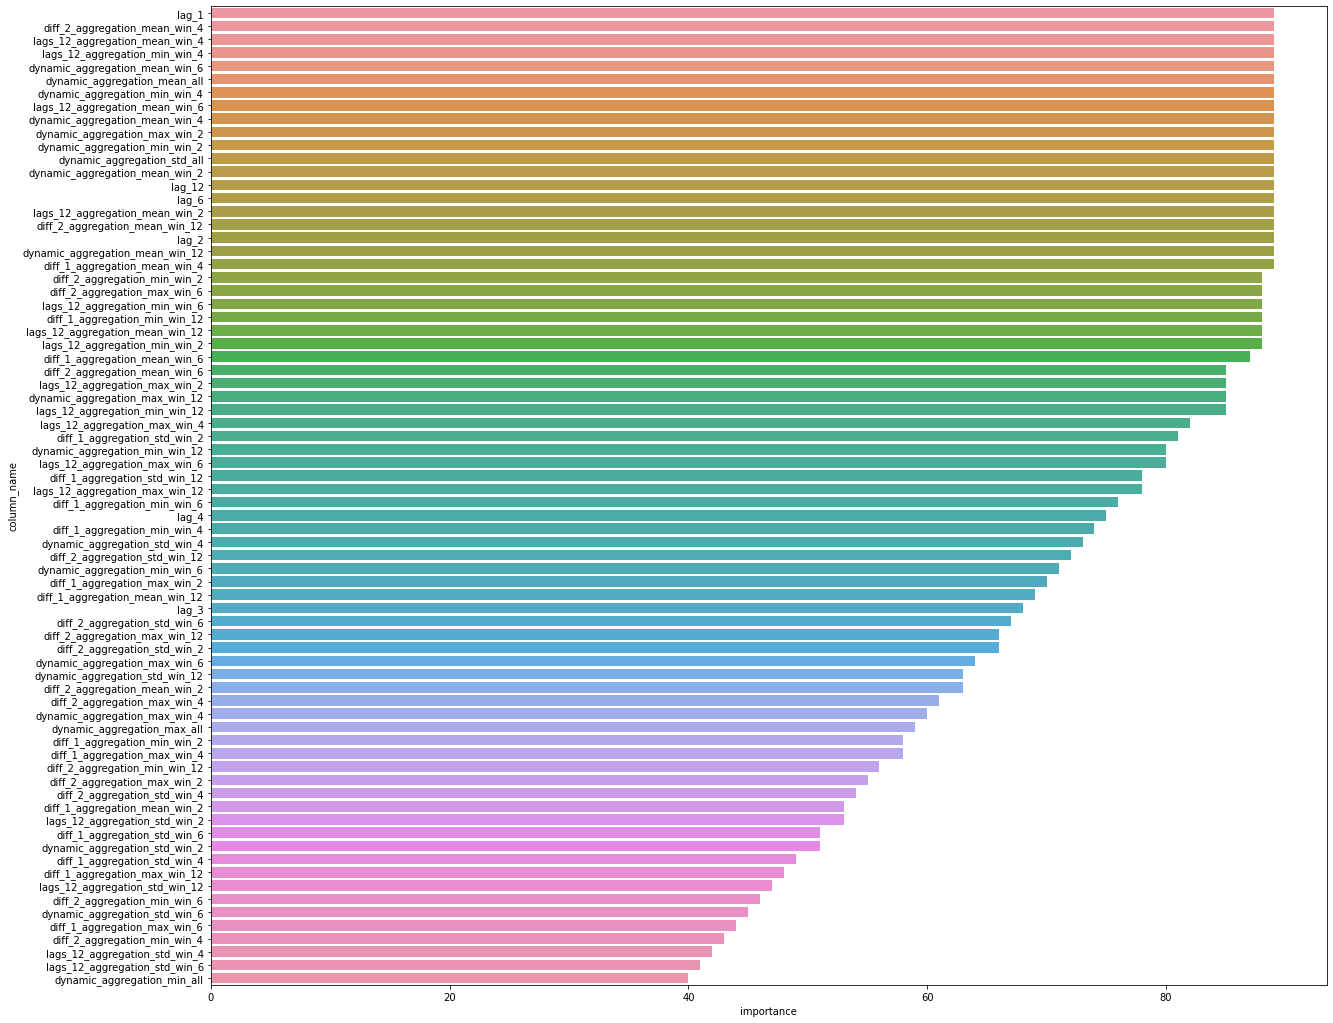

In [20]:
_, axs = plt.subplots(1, 1, figsize=(20, 18))

sns.barplot(data=select.reset_index(), x='importance', y='column_name', ax=axs)

In [21]:
train_x = train_x.loc[:,select[select.importance >= 87].index].reset_index().rename({'index': 'id'},axis=1).merge(task_df['idx'][['shop_id', 'item_id', 'id']], on='id').set_index('id')
test_x = test_x.loc[:,select[select.importance >= 87].index].reset_index().rename({'index': 'id'},axis=1).merge(task_df['idx'][['shop_id', 'item_id', 'id']], on='id').set_index('id')
eval_x = eval_x.loc[:,select[select.importance >= 87].index].reset_index().rename({'index': 'id'},axis=1).merge(task_df['idx'][['shop_id', 'item_id', 'id']], on='id').set_index('id')

## Basic models

### We gonna check 3 models (ElasticNet, Random Forest, XGBoost) 

1) Validation model

In [22]:
from sklearn.metrics import mean_squared_error as mse

class Validator:
    def __init__(self, model, **kwargs) -> None:
        self.model = model(**kwargs)
        self._context = {}

    def fit(self, x, y, trained_model=None):
        if trained_model is None:
            self.model.fit(x, y)
        else:
            self.model = trained_model

        return self.model

    def validate(self, x, y):
        
        predictions = self.model.predict(x)
        truth = y

        return mse(predictions, truth), predictions, truth

In [23]:
errors = {}

2) ElasticNet (CRUSHES ALL THE TIME) + ISSUE | Use Ridge instead

In [39]:
# lis = [[], []]

# for alpha_ in range(-8, 0):
#     print(alpha_)
#     validator_lin = Validator(Ridge, alpha=10**(alpha_))
    
#     validator_lin.fit(train_x, train_y)
#     err = validator_lin.validate(test_x, test_y)[0]

#     lis[0].append(alpha_)
#     lis[1].append(err)

# sns.scatterplot(*lis)

In [34]:
lin_validator = Validator(Ridge, alpha=1e-7)

lin_validator.fit(train_x, train_y)
errors['ridge'] = lin_validator.validate(test_x, test_y)
errors['ridge'][0]

with open('tmp/ridge_error.pkl', 'wb+') as writer:
        pickle.dump(errors['ridge'], writer)


3) Random Forest

In [40]:
lin_validator = Validator(RandomForestRegressor, n_jobs=-1, max_depth=40)

lin_validator.fit(train_x, train_y)
errors['rfr'] = lin_validator.validate(test_x, test_y)
errors['rfr'][0]

with open('tmp/rfr_error.pkl', 'wb+') as writer:
        pickle.dump(errors['rfr'], writer)

19.715914452972015

4. XGBoost

In [45]:
from xgboost import XGBRegressor

In [51]:
xgb_validator = Validator(XGBRegressor, n_estimators=100, learning_rate=0.7, n_jobs=4, max_depth=10, reg_alpha=0)

xgb_validator.fit(train_x, train_y)
errors['xgb'] = xgb_validator.validate(test_x, test_y)

with open('tmp/xgb_error.pkl', 'wb+') as writer:
        pickle.dump(errors['xgb'], writer)
errors['xgb'][0]

19.580747154805838

## Now we gonna make test residual set

In [52]:
xgb_validator = Validator(XGBRegressor, n_estimators=100, learning_rate=0.7, n_jobs=4, max_depth=10, reg_alpha=0)

xgb_validator.fit(test_x, test_y)
errors['xgb'] = xgb_validator.validate(eval_x, eval_y)

with open('tmp/xgb_error.pkl', 'wb+') as writer:
        pickle.dump(errors['xgb'], writer)
errors['xgb'][0]

22.513062237516852

As we see we can easily overtune our model, so u're welcome to 'residual analysis'